<h1><center>Mountain Car Problem</center></h1>

<h2><center>Part 2: Deep Learning</center></h2>

<h3><center>Claudia Afonso</center><h3>

---

This second notebook contains the part of the project related with Deep Q-learning. The first notebook contains the part of the project related with Q-learning. The comparison between the two trained agents can be found in this notebook at the end.

## 3. Training an agent with Deep Reinforcement Learning

### 3.1. Deep Q-Learning

The idea behind deep Q-learning (DQN) consists of combining Q-learning with deep learning. Instead of using the Q-table to store and update the values of the state-action pairs, neural networks are used to approximate the optimal action value function, $Q_{opt}(s,a)$. The network receives a given state as input and produces the estimated Q-values as outputs (one for each action).

To train the network, the ground truth is created on the run by using the Bellman equation:

<br>
<center>$Q(s,a) = r + \gamma \max_{a} Q(s',a)$</center>

Thus, here we are approximating the current action value $Q(s,a)$ based on an estimate of the future $Q(s',a)$ value. Therefore, two separate networks need to be used, the first to estimate the current values and the second to estimate the future (target) values. The weights of the first network (the policy network) are updated to move the predictions closer to the target Q-values. Every C time step, the weights from the policy network are copied to the second network (the target network). This two-network solution provides stability to the DQN algorithm, since it uses separate networks to produce estimates (one for the current Q-value and another for the future Q-value).

Successive experiences in a sequence of interactions are highly correlated with each other and this can lead to instability during training. Thus, the DQN algorithm uses the biologically-inspired `Experience Replay` mechanism, which serves to store past experiences (that is, state, action, reward, future state values). This experience replay is sampled according to a given batch size to retrieve past experiences, thereby randomizing and breaking the temporal correlation in the data.

The pseudocode for implementing the DQN algorithm is the following:

<img src="Pseudocode_DQN.jpg" width="500" height="340"/>

### 3.2. Applying Deep Q-Learning to the Mountain Car problem

Here, the tutorial at TensorFlow (https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) was followed to implement a DQN agent to the Mountain Car problem. Since DQN can handle problems with continuous state spaces, it was not necessary to perform discretization as done in the case of Q-learning.

#### 3.2.1 Setup

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install tf-keras

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already th

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from IPython.display import HTML
from base64 import b64encode
from google.colab import files
import time

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

#### 3.2.2 Defining the Hyperparameters

In [5]:
num_iterations = 500000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

A linear epsilon decay as the number of iterations during training increased was also used, as previously done for Q-learning. 

In [6]:
global_step = tf.Variable(0, trainable=False)
epsilon_init = 0.55
min_epsilon = 0.05
decay_steps = num_iterations
epsilon = tf.compat.v1.train.polynomial_decay(epsilon_init,
                                              global_step,
                                              decay_steps,
                                              min_epsilon,
                                              power=1.0)

In [7]:
gamma = 0.9

#### 3.2.3 Environment

In [8]:
env_name = 'MountainCar-v0'
env = suite_gym.load(env_name)

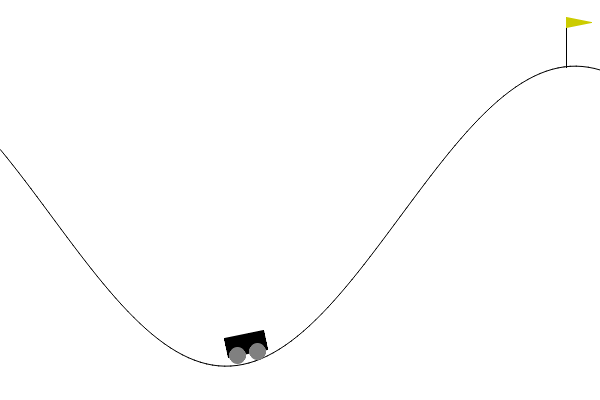

In [9]:
env.reset()
PIL.Image.fromarray(env.render())

In [10]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [11]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#### 3.2.4 Agent

In [12]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    gamma=gamma,
    epsilon_greedy=epsilon,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    target_update_tau=0.005,
    target_update_period=5)

agent.initialize()

#### 3.2.5 Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome. In the case of the Mountain Car problem, the desired outcome is for the car to reach the flag on the right hill. 

For each time_step observation, the policy returns an action:
* `0: Accelerate to the left`
* `1: Don’t accelerate`
* `2: Accelerate to the right`

Agents contain two policies: 

* `agent.policy` - the main policy that is used for evaluation and deployment

* `agent.collect_policy` - a second policy that is used for data collection

In [14]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. In this case, a `random_policy` was created that randomly selects an action for each time_step.

In [15]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the policy.action(time_step) method. The time_step contains the observation from the environment. This method returns a PolicyStep, which is a named tuple with three components:

* `action` — the action to be taken (in this case, 0 or 1)
* `state` — used for stateful (that is, RNN-based) policies
* `info` — auxiliary data, such as log probabilities of actions

In [16]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('MountainCar-v0'))

In [17]:
time_step = example_environment.reset()

In [18]:
time_step

TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.5830122,  0.       ]], dtype=float32)>})

In [19]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

#### 3.2.6 Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

In [20]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

The average return of a random policy can be computed, which gives -200.0. This will serve as a benchmark to check whether the agent is learning throughout the training process.

In [21]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-200.0

#### 3.2.7 Replay Buffer

In order to keep track of the data collected from the environment, `Reverb` was also used, which is a replay system by Deepmind that only runs in Linux-based Operating Systems. Since this notebook was ran in Colab, it was also possible to `Reverb` there. The function of the replay buffer is to store experience data when collecting trajectories and is consumed during training. This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.

In [22]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

For most agents, `collect_data_spec` is a named tuple called Trajectory, containing the specs for observations, actions, rewards, and other items.

In [23]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation', minimum=array([-1.2 , -0.07], dtype=float32), maximum=array([0.6 , 0.07], dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [24]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

#### 3.2.8 Data Collection

Now the random policy in the environment is executed for a few steps, recording the data in the replay buffer. Here, 'PyDriver' is used to run the experience collecting loop.

In [25]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.517807  , -0.00073633], dtype=float32)}),
 ())

The replay buffer is now a collection of Trajectories.

In [26]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-5.1958227e-01, -5.3331786e-04],
        [-5.1914573e-01,  4.3655929e-04]], dtype=float32)>,
  'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>,
  'policy_info': (),
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1., -1.], dtype=float32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([756609591310377412, 756609591310377412], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>, time

The agent needs access to the replay buffer. This is provided by creating an iterable tf.data.Dataset pipeline which will feed data to the agent. Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (num_steps=2). This dataset is also optimized by running parallel calls and prefetching data.

In [27]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 2), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [28]:
iterator = iter(dataset)

#### 3.2.9 Training the Agent

Two things must happen during the training loop:

* collect data from the environment
* use that data to train the agent's neural network(s)

The policy is also periodically evaluated and the current score printed.

In [29]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

start_time = time.time()

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

end_time = time.time()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 0.14048108458518982
step = 400: loss = 0.0074961064383387566
step = 600: loss = 0.012236947193741798
step = 800: loss = 0.01514175534248352
step = 1000: loss = 0.02781202457845211
step = 1000: Average Return = -200.0
step = 1200: loss = 0.012369811534881592
step = 1400: loss = 0.009981459006667137
step = 1600: loss = 0.017119042575359344
step = 1800: loss = 0.010994571261107922
step = 2000: loss = 0.011184653267264366
step = 2000: Average Return = -200.0
step = 2200: loss = 0.03767845034599304
step = 2400: loss = 0.07815498113632202
step = 2600: loss = 0.009657658636569977
step = 2800: loss = 0.006783921737223864
step = 3000: loss = 0.006777910050004721
step = 3000: Average Return = -200.0
step = 3200: loss = 0.0038203070871531963
step = 3400: loss = 0.004134439863264561
step = 3600: loss = 0.004961574450135231
step = 3800: loss = 0.005959300324320793
step = 4000: loss = 0.002890238305553794
step = 4000: Average Return = -200.0
step = 4200: loss = 0.00473066978156566

#### 3.2.10 Visualization and Training Time Determination

One iteration of Mountain Car consists of 200 time steps. The environment gives a reward of -1 for each step the agent takes, so the minimum return for one episode is -200 (which corresponds to the average reward of the random policy). The chart below shows the return increasing from -200 when the number of iterations reaches the value of approximately 240000. From this time step onwards, the agent begins to learn. This is likely due to the decrease in epsilon values that occurs as the training evolves. Thus, the actions start to be less random as the training evolves, with the agent taking advantage of its learned knowledge.

(-204.175, 250.0)

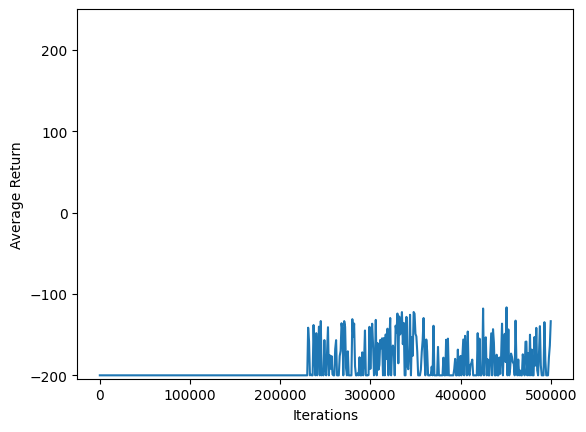

In [30]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [31]:
total_time = end_time - start_time
minutes = total_time // 60
seconds = total_time % 60
seconds = round(seconds, 3)
print(f'The training took {minutes} minutes and {seconds} seconds')

The training took 254.0 minutes and 5.902 seconds


Videos of the trained agent were also created and compared it with the one following a random policy. Since the embedded videos disappear as the Notebook is downloaded from Colab, the download of these videos was performed in addition to rendering them within Colab. The corresponding videos can be found within this project folder and are named "trained-agent.mp4" and "random-agent.mp4".

As observed from the these videos, in all five iterations of the Mountain Car game with the trained agent, the car reached its goal. Comparing the trained agent with the random agent (which follows a random policy), the latter was never able to reach its goal during five iterations of the game.

In [32]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())

    return files.download(filename)

In [33]:
create_policy_eval_video(agent.policy, "trained-agent")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
create_policy_eval_video(random_policy, "random-agent")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Comparing the two trained agents using Q-learning and Deep Q-Learning

It was possible to train two agents for the Mountain Car problem using both Q-learning and Deep Q-Learning. In the former case, it was necessary to perform discretization of the observation space to perform training. For the "best produced" agent, the training took almost 8 minutes. In all five iterations of the Car Mountain game, this trained agent following our approximated best policy was able to reach its goal, taking between 115 to 158 steps. For the agent trained with Deep Q-Learning, in five iterations of the Car Mountain game the trained agent was also able to reach its goal. The training in this case took considerably longer Q-learning at slightly more than 254 minutes (more than 4 hours).

To conclude, it appears that deep reinforcement learning using Q-learning outperforms Deep Q-learning for the Mountain Car problem, since the training time of the former was much lower than the latter with comparable results. Indeed, training neural networks to estimate Q-values for the Mountain Car problem took much longer than simply using tabular Q-learning for this task. This might be due to the fact that the Mountain Car environment is relatively simple with a low-dimensional state space. It should also be noted that it was considerably easier to train the agent with Q-learning in comparision with Deep Q-Learning. In addition to the already mentioned training duration, the `Reverb` replay system only works in Colab or Linux-based operating systems, which made the training with Deep Q-Learning more difficult since Colab would periodically restart during execution time.